In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression,Ridge
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import make_pipeline
from category_encoders import OneHotEncoder

In [2]:
def wrangle(filepath):
    df=pd.read_csv(filepath)
    
    
    #price type from string to float
    mask_RRp=df["RRP"] != "POR"
    df=df[mask_RRp]
    df["RRP"]=df["RRP"].astype(float)
    
    #remove outlires
    mask_price=df["RRP"] < 150000
    df=df[mask_price]
    #drop columns with more than 50% null
    df.drop(columns="Complication/2",inplace=True)
    
    df.dropna(inplace=True)
    df.drop(columns="Reference",inplace=True)
    #df.drop(columns="Description",inplace=True)
    df.rename(columns = {'Complication/0':'Complication_0', 'Complication/1':'Complication_1'}, inplace = True)
    #df.drop(columns="Complication1",inplace=True)
    #df.drop(columns="Complication2",inplace=True)

    return df

In [3]:
df=wrangle("data/Rolex_retail_original.csv")

In [4]:
df.head()

,Size,Collection,Description,RRP,Complication_0,Complication_1
1,40,Cosmograph Daytona,Standard Dial,12600.0,Chronograph,Small Seconds
2,40,Cosmograph Daytona,Standard Dial,16800.0,Chronograph,Small Seconds
3,40,Cosmograph Daytona,Diamond Dial,18720.0,Chronograph,Small Seconds
4,40,Cosmograph Daytona,Mother of Pearl Diamond Dial,21360.0,Chronograph,Small Seconds
5,40,Cosmograph Daytona,Standard Dial,37860.0,Chronograph,Small Seconds


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 540 entries, 1 to 886
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Size            540 non-null    int64  
 1   Collection      540 non-null    object 
 2   Description     540 non-null    object 
 3   RRP             540 non-null    float64
 4   Complication_0  540 non-null    object 
 5   Complication_1  540 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 29.5+ KB


Text(0.5, 0, 'Price')

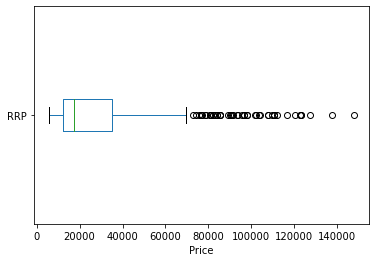

In [6]:
df["RRP"].plot.box(vert=False)
plt.xlabel("Price")

In [7]:
df["Complication_0"].unique()

array(['Chronograph', 'Date', 'Day Date', 'Regatta Chronograph',
       'Dual Time'], dtype=object)

In [8]:
df["Complication_1"].unique()

array([' Small Seconds', ' Stop Seconds', ' GMT', ' Date', ' Diver',
       ' Day and Night Indicator', ' Moonphase'], dtype=object)

In [9]:
df["Size"].unique()

array([40, 36, 41, 28, 44, 31, 42, 43, 37, 39], dtype=int64)

In [23]:
df["Description"].unique()

array(['Mother of Pearl Diamond Dial\xa0President Bracelet',
       'Diamond Dial Oyster Bracelet', 'Standard Dial Oyster Bracelet',
       'Mother of Pearl Diamond Dial Oyster Bracelet',
       'Mother of Pearl Diamond Dial', 'Standard Dial',
       'Standard Dial President Bracelet', 'Diamond Dial',
       'Meteorite Diamond Dial Jubilee Bracelet',
       'Mother of Pearl Dial Jubilee Bracelet',
       'Diamond Dial President Bracelet', 'Pave Diamond Dial',
       'Diamond VI Dial President Bracelet',
       'Mother of Pearl Diamond Dial President Bracelet',
       'Diamond Emerald Dial', 'Mother of Pearl Dial Oyster Bracelet',
       'Pave Sapphire Dial President Bracelet', 'Date',
       'Diamond 6 & 9 Dial Jubilee Bracelet',
       'Mother of Pearl Diamond Dial Jubilee Bracelet',
       'Diamond Dial Jubilee Bracelet', 'Diamond VI Dial JubileeBracelet',
       'Diamond VI Dial Oyster Bracelet',
       'Mother of Pearl Diamond Dial Diamond\xa0President Bracelet',
       'Malachite 

In [10]:
df["Collection"].unique()

array(['Cosmograph Daytona', 'Datejust', 'Deepsea Sea-Dweller',
       'GMT-Master II', 'Day-Date', 'Explorer II', 'Sea-Dweller',
       'Sky-Dweller', 'Submariner', 'Yacht-Master', 'Yacht-Master II',
       'Cellini'], dtype=object)

In [11]:
cutoff=int(len(df["RRP"])*0.8)

In [12]:
df=df.sample(frac=1).reset_index(drop=True)

In [13]:
feature=df.drop(columns="RRP")
target=df["RRP"]

X_train,y_train= feature.iloc[:cutoff],target.iloc[:cutoff]
X_test,y_test= feature.iloc[cutoff:],target.iloc[cutoff:]

In [14]:
X_train.shape

(432, 5)

In [15]:
y_test.shape

(108,)

In [16]:
y_mean=y_train.mean()
y_base_line=[y_mean]*len(y_train)
mae_basline=mean_absolute_error(y_train,y_base_line)
print("Mean Rolex price:", y_mean)
print("Base line:", y_base_line[:5])
print("MAE_baseline:", mae_basline)

Mean Rolex price: 29001.944444444445
Base line: [29001.944444444445, 29001.944444444445, 29001.944444444445, 29001.944444444445, 29001.944444444445]
MAE_baseline: 18258.72427983539


In [17]:
model=make_pipeline(
    OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    Ridge()
)
model.fit(X_train,y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Collection', 'Description',
                                     'Complication_0', 'Complication_1'],
                               use_cat_names=True)),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [18]:
y_pred_training = model.predict(X_train)
mae_training = mean_absolute_error(y_train,y_pred_training)
print("Training MAE:", mae_training)

Training MAE: 7410.920313397613


In [19]:
y_pred_test = pd.Series(model.predict(X_test))
y_pred_test.head()

0    18924.558247
1    78652.642555
2    15240.856532
3    15240.856532
4    37934.873957
dtype: float64

In [20]:
mae_test=mean_absolute_error(y_test,y_pred_test)
print("Mea test : ",mae_test)

Mea test :  9092.809222361671


In [26]:
def make_prediction(Size, Collection,Description,Complication_0,Complication_1):
    data={"Size":Size,
          "Collection":Collection,
          "Description":Description,
          "Complication_0":Complication_0,
           "Complication_1":Complication_1,
}
    df=pd.DataFrame(data,index=[0])
    prediction = model.predict(df).round(2)[0]
    return f"Predicted Rolex {Collection} price: ${prediction}"

In [38]:
make_prediction(40,"Cosmograph Daytona","Green Dial with Red Accents","Chronograph","Small Seconds")

'Predicted Rolex Cosmograph Daytona price: $53226.54'